# Intro

### This project is meant to be a sign language detection deep learning model using pre-recorded videos

# Import Dependencies

In [1]:
# !pip install --upgrade pip

In [2]:
# !pip install tensorflow
# !pip install opencv-python
# !pip install mediapipe
# !pip install matplotlib
# !pip install imgaug
# !pip install scikit-learn


In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import matplotlib.image as mpimg
import pickle
import imgaug.augmenters as iaa
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed
from skimage.transform import resize
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from skimage.transform import resize

# Keypoints using Mediapipes Holistic

In [4]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [5]:
def draw_landmarks(image, results, mp_drawing, mp_holistic):
    landmark_types = {
        "face_landmarks": (results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, (80, 110, 10), 1, 1),
        "pose_landmarks": (results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, (80, 22, 10), 2, 2),
        "left_hand_landmarks": (results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, (121, 22, 76), 2, 2),
        "right_hand_landmarks": (results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, (121, 22, 76), 2, 2)
    }

    for landmark_type, (landmarks, connections, color, thickness, circle_radius) in landmark_types.items():
        if landmarks is not None:
            mp_drawing.draw_landmarks(
                image,
                landmarks,
                connections,
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=color, thickness=thickness, circle_radius=circle_radius),
                connection_drawing_spec=mp_drawing.DrawingSpec(color=color, thickness=thickness),
            )

#### The cell above define a function called draw_landmarks that draws landmarks on images. 
#### It uses the Mediapipe library to extract landmarks for different body parts which in our case are face, pose, and hands landmarks and then visualize them on images. This function is essential for analyzing, using and understanding the detected body features in our images.

<br>

In [6]:
def mediapipe_detection(image, model):
    image.flags.writeable = False
    results = model.process(image)
    return image, results

def convert_results_to_dict(frame_results):
    converted_results = {}
    converted_results["face_landmarks"] = frame_results.face_landmarks
    converted_results["pose_landmarks"] = frame_results.pose_landmarks
    converted_results["left_hand_landmarks"] = frame_results.left_hand_landmarks
    converted_results["right_hand_landmarks"] = frame_results.right_hand_landmarks
    return converted_results

#### This cell block defines the "convert_results_to_dict" function. It takes frame_results as input, which represents the results obtained from the mediapipe holistic detection. 
#### The function extracts the necessary information from frame_results, so that we have access to pose, right hand, left hand and face landmarks. 
#### It then stores this information in a dictionary and returns it.

#### I decided to do it this way as we are using already recorded videos, each time we restarted the kernel we would lose access to the landmarks as well as the data for each frame.
#### This way we store the frames and have the results, and landmarks stored for each video.


<br>

In [7]:
video_folder_path = './Videos'
output_folder = './Results'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#### This cell block sets the paths for the input video folder (video_folder_path) and the output folder for results (output_folder). 
#### Then it checks if the output folder exists, and in the case it doesn't, it creates the new output folder using the method os.makedirs().

</br>

In [8]:
for subfolder_name in os.listdir(video_folder_path):
    subfolder_path = os.path.join(video_folder_path, subfolder_name) # iterate over the subfolders

    if os.path.isdir(subfolder_path):
        for video_file in os.listdir(subfolder_path):
            video_path = os.path.join(subfolder_path, video_file)
            video_name = os.path.splitext(video_file)[0]
            frames_dir = os.path.join(subfolder_path, f'{video_name}_frames')

            if os.path.exists(frames_dir): # check if the frames folder already exists
                break

            os.makedirs(frames_dir, exist_ok=True)

            frames_exist = any(f.startswith(f'{video_name}_frame_') for f in os.listdir(frames_dir))

            if frames_exist:
                results_file_path = os.path.join(output_folder, subfolder_name, f'{video_name}_results.pkl')
                if os.path.exists(results_file_path):
                    continue

            results = []

            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                frame_count = 0
                max_frame_count = 50  # This is to "cut" the video, by selecting the maximum number of frames the video has, i tried to aim to make them all the same size
                video = cv2.VideoCapture(video_path)

                while video.isOpened() and frame_count < max_frame_count:
                    ret, frame = video.read()

                    if not ret:
                        break

                    image, frame_results = mediapipe_detection(frame, holistic)
                    converted_results = convert_results_to_dict(frame_results)
                    results.append(converted_results)

                    draw_landmarks(image, frame_results, mp_drawing, mp_holistic)

                    cv2.imshow('OpenCV Video Detection', image)
                    cv2.waitKey(1)

                    frame_filename = f'{video_name}_frame_{frame_count}.jpg'
                    frame_path = os.path.join(frames_dir, frame_filename)

                    cv2.imwrite(frame_path, image)

                    frame_count += 1

                video.release()
                cv2.destroyAllWindows()

            if not frames_exist:
                results_file_path = os.path.join(output_folder, subfolder_name, f'{video_name}_results.pkl')
                os.makedirs(os.path.dirname(results_file_path), exist_ok=True)
                with open(results_file_path, 'wb') as results_file:
                    pickle.dump(results, results_file)


#### To optimize efficiency, the code incorporates several fail-safes. First, it verifies the existence of frames and results for each video to prevent repeated processing. If the frames and results are already available, the corresponding video is skipped to avoid duplicating files or creating new unwanted files. Like for example, when running the code, and after already having a frames folder, as well as a results folder, it would create a new file called frames_result.pkl based on the frames folder, which was wrong.

#### Another issue I would often encounter, was losing the 'results' variable each time I restarted the kernels, which serve the purpose of letting me analyze the frames, to correct this problem, the code ensures the preservation of prior analyses by checking the presence of a created results file. This solution allows me to access the video frame results and the detected and stored landmarks for subsequent analysis whenever needed.


#### I also opted to use pickle for this project, for the reason that, by using 'pickle.dump(results, results_file)', the script serializes the results object and writes it to a pickle file. This allows the results to be easily saved and loaded for subsequent usage.

#### When needed, such as after the kernels restart, the script can load the saved results from the pickle file using 'pickle.load(results_file)'. This deserializes the data, making us able to use it as a python object, it also allows us to not have to lose the results and having to delete everything for each usage.

#### The usage of pickle provides a convenient and efficient way to store and retrieve complex data structures, giving us access to every video data analyses and enabling further processing and research for the extracted landmarks and frame data. 

<br>

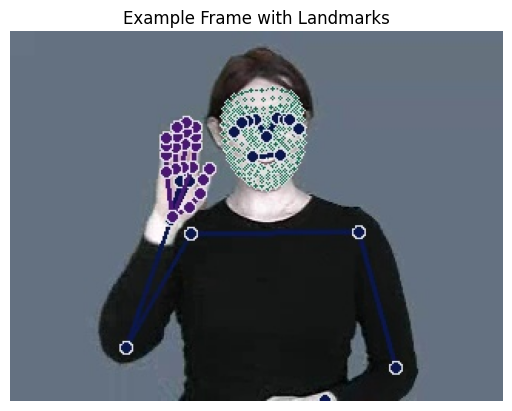

In [9]:
img_path = './Videos/hello/hello_0_frames/hello_0_frame_10.jpg'
img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.title('Example Frame with Landmarks')
plt.show()


#### With this, we now have a functional script that reads the video, turns it into frames while applying the mediapipe's holistic module for pose, right hand, left hand and face landmarks.
#### As the image annexed above shows, we also have the connections for each landmark point that was detected.

</br>

# Data Augmentation

In [10]:
def apply_random_noise(video_path, variance, num_frames_to_process):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while frame_count < num_frames_to_process:
        ret, frame = cap.read()
        if not ret:
            break

        frame = frame.astype(np.float32)
        noise = np.random.normal(0, variance, frame.shape).astype(np.float32)
        noisy_frame = np.clip(frame + noise, 0, 255).astype(np.uint8)

        frames.append(noisy_frame)
        frame_count += 1

    cap.release()
    return frames


def apply_random_rotation(video_path, angle_range, num_frames_to_process):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while frame_count < num_frames_to_process:
        ret, frame = cap.read()
        if not ret:
            break

        angle = np.random.uniform(angle_range[0], angle_range[1])
        rotation_matrix = cv2.getRotationMatrix2D((frame.shape[1] / 2, frame.shape[0] / 2), angle, 1)
        rotated_frame = cv2.warpAffine(frame, rotation_matrix, (frame.shape[1], frame.shape[0]))

        frames.append(rotated_frame)
        frame_count += 1

    cap.release()
    return frames


def apply_speed_perturbations(video_path, speed_factor, num_frames_to_process):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while frame_count < num_frames_to_process:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % speed_factor == 0:
            frames.append(frame.copy())

        frame_count += 1

    cap.release()
    return frames


In [11]:
mp_holistic_module = mp.solutions.holistic
def process_augmented_frames(frames, mp_holistic_module, mp_drawing):
    processed_frames = []
    mp_drawing_utils = mp_drawing

    with mp_holistic_module.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as holistic:
        for frame in frames:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.flip(frame_rgb, 1)
            image.flags.writeable = False
            results = holistic.process(image)

            draw_landmarks(image, results, mp_drawing_utils, mp_holistic_module)

            frame_results = convert_results_to_dict(results)

            processed_frames.append(image)

    return processed_frames

In [12]:
video_folder_path = './Videos'
output_folder = './Results'
num_frames_to_process = 50

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

augmented_folders = ['Augmented_RandomNoise', 'Augmented_RandomRotation', 'Augmented_SpeedPerturbations']
aug_techniques = {
    'Augmented_RandomNoise': 'Random Noise',
    'Augmented_RandomRotation': 'Random Rotation',
    'Augmented_SpeedPerturbations': 'Speed Perturbations'
}

for subfolder_name in os.listdir(video_folder_path):
    subfolder_path = os.path.join(video_folder_path, subfolder_name)

    if os.path.isdir(subfolder_path):
        for video_file in os.listdir(subfolder_path):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(subfolder_path, video_file)
                video_name = os.path.splitext(video_file)[0]

                for technique_folder, technique_name in aug_techniques.items():
                    results_file_path = os.path.join(output_folder, technique_folder,
                                                     f'{video_name}_{technique_name.replace(" ", "_")}_augmented_results.pkl')

                    if os.path.exists(results_file_path):
                        continue

                    augmentation_params = {
                        'Random Noise': {
                            'variance': 0.1,
                        },
                        'Random Rotation': {
                            'angle_range': (-10, 10),
                        },
                        'Speed Perturbations': {
                            'speed_factor': 2.0,
                        }
                    }

                    if technique_name == 'Random Noise':
                        augmented_video_frames = apply_random_noise(video_path, augmentation_params[technique_name]['variance'], num_frames_to_process)
                    elif technique_name == 'Random Rotation':
                        augmented_video_frames = apply_random_rotation(video_path, augmentation_params[technique_name]['angle_range'], num_frames_to_process)
                    elif technique_name == 'Speed Perturbations':
                        augmented_video_frames = apply_speed_perturbations(video_path, augmentation_params[technique_name]['speed_factor'], num_frames_to_process)

                    results = process_augmented_frames(augmented_video_frames, mp_holistic_module, mp_drawing)

                    os.makedirs(os.path.dirname(results_file_path), exist_ok=True)

                    with open(results_file_path, 'wb') as results_file:
                        pickle.dump(results, results_file)


#### The code cell above collects frames from the iterated video folders and applies data augmentation techniques to generate augmented frames.

#### Unlike the first video extraction process we have, in this case we don't extract the frames, the frames are directly processed using the using Mediapipe Holistic to extract keypoints, which represent points such as facial, pose, and hand landmarks.

#### The extracted keypoints are stored in separate results files for each video, allowing for further analysis and processing based on the extracted keypoints, considering we are extracting the keypoints firectly as we apply them it allows less loss of data as it would be if we extracted the landmarks from the frames, which was something i noticed while making this.

<br>

#### Each sign / word in our dataset has 3 corresponding videos, and each video passes through three Data Augmentation techniques, mainly "Random Noise", "Random Rotation", and "Speed Perturbations".

#### These techniques add controlled variations in the frames we extracted from the videos in cells above, adding new randomness and realistic distortions. By applying these techniques, we create a more diverse dataset that better represents real-world cases, like lighting conditions, or recording angles, enabling our model to generalize and perform better in various conditions. 

<br>